# Credit Score Classification

# 1- EDA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from enum import Enum, EnumMeta
from collections import Counter, defaultdict
from datetime import datetime

import utils.pd as pd_utils

from sklearn.preprocessing import (
StandardScaler, MinMaxScaler,
OrdinalEncoder, OneHotEncoder,
FunctionTransformer
)

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score

from imblearn.pipeline import Pipeline as Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


import optuna
from IPython.display import display

In [2]:
df = pd.read_csv("data/credit_score/train.csv", low_memory=False)

In [3]:
df.shape

(100000, 28)

In [4]:
df.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


In [5]:
# class DisplayType(Enum):
#     head = 1
#     tail = 2
#     sample = 3

In [6]:
# def display_dataframe(df: pd.DataFrame, display_type: DisplayType=DisplayType.head, 
#                       n_cols: int=None, n_rows: int=5):
    
#     n_cols = df.columns.size if n_cols is None else n_cols
    
#     with pd.option_context('display.max_columns', n_cols):
#         if display_type.name == 'head':
#             display(df.head(n_rows))
#         elif display_type.name == 'tail':
#             display(df.tail(n_rows))
#         elif display_type.name == 'sample':
#             display(df.sample(n_rows))
#         else:
#             raise ValueError('The entered display_type is not supported.')

In [7]:
pd_utils.display_dataframe(df)

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,11.27,4.0,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1,NaN,11.27,4.0,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,_,4.0,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",5,4,6.27,4.0,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",6,NaN,11.27,4.0,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

In [9]:
cols_to_num = ['Age', 'Annual_Income', 'Num_of_Loan', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Outstanding_Debt', 'Amount_invested_monthly', 'Monthly_Balance']

In [10]:
def series_report(series:pd.Series, is_categorical=False):
    non_numeric_vals = series[pd.to_numeric(series, errors='coerce').isna()]
    value_counts = non_numeric_vals.value_counts()
    print(f"Column \"{series.name}\"")
    print("="*47)
    print(f"[{'All entries':^21}] Unique / Non-null : {series.unique().size}/{series.count()}")
    if not is_categorical:
        print(f"[{'Non-numeric entries':^21}] unique / All : {value_counts.index.size}/{value_counts.sum()}")
    print(f"{value_counts}")
    print("-"*50, "\n")

In [11]:
for col in cols_to_num:
    series_report(df[col])

Column "Age"
[     All entries     ] Unique / Non-null : 1788/100000
[ Non-numeric entries ] unique / All : 127/4939
Age
24_      161
38_      161
29_      160
26_      153
27_      152
        ... 
1248_      1
3055_      1
6666_      1
2463_      1
4808_      1
Name: count, Length: 127, dtype: int64
-------------------------------------------------- 

Column "Annual_Income"
[     All entries     ] Unique / Non-null : 18940/100000
[ Non-numeric entries ] unique / All : 5503/6980
Annual_Income
14388.79_    5
42904.26_    5
45455.94_    4
9275.95_     4
28381.96_    4
            ..
20067.05_    1
8796.905_    1
10046.24_    1
32187.36_    1
35812.34_    1
Name: count, Length: 5503, dtype: int64
-------------------------------------------------- 

Column "Num_of_Loan"
[     All entries     ] Unique / Non-null : 434/100000
[ Non-numeric entries ] unique / All : 35/4785
Num_of_Loan
2_       782
4_       727
3_       718
0_       550
1_       523
7_       414
6_       398
5_       332
9_  

In [12]:
strange_vals_mapping = {'__-333333333333333333333333333__': pd.NA, 
                        '__10000__': pd.NA}

In [13]:
def sanitize_numeric_series(s:pd.Series):
    return s.str.replace(r'[^0-9.]', '', regex=True)

In [14]:
df2 = (
    df.Credit_History_Age.str.extract(r'(\d+) Years and (\d+) Months')
    .rename(columns={0:'Credit_History_Years', 1:'Credit_History_Months'})
    .pipe(lambda df_: pd.concat([df, df_], axis=1))
    .assign(**{c: lambda df_, c=c: pd.to_numeric(df_[c]) for c in ['Credit_History_Years', 'Credit_History_Months']})
    .assign( Credit_History_Age = lambda df_: df_.Credit_History_Years*12 + df_.Credit_History_Months)
    .pipe(lambda df_: df_.drop(['Credit_History_Years', 'Credit_History_Months'], axis=1))
    .assign(**{c: lambda df_, c=c: df_[c].replace(strange_vals_mapping) for c in cols_to_num})
    .assign(**{c: lambda df_, c=c: sanitize_numeric_series(df_[c]) for c in cols_to_num})
    .assign(**{c: lambda df_, c=c: df_[c].replace('', pd.NA) for c in cols_to_num})
    .assign(**{c: lambda df_, c=c: pd.to_numeric(df_[c]) for c in cols_to_num})
)

In [15]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  int64  
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  float64
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  int64  
 13  Type_of_Loan              88592 non-null   ob

In [17]:
pd_utils.display_df_desc(df2)

,count,mean,std,min,25%,50%,75%,max
Age,100000.000,119.510,684.757,14.000,25.000,34.000,42.000,8698.000
Annual_Income,100000.000,176415.701,1429618.051,7005.930,19457.500,37578.610,72790.920,24198062.000
Monthly_Inhand_Salary,84998.000,4194.171,3183.686,303.645,1625.568,3093.745,5957.448,15204.633
Num_Bank_Accounts,100000.000,17.091,117.405,-1.000,3.000,6.000,7.000,1798.000
Num_Credit_Card,100000.000,22.474,129.057,0.000,4.000,5.000,7.000,1499.000
Interest_Rate,100000.000,72.466,466.423,1.000,8.000,13.000,20.000,5797.000
Num_of_Loan,100000.000,10.762,61.790,0.000,2.000,3.000,6.000,1496.000
Delay_from_due_date,100000.000,21.069,14.860,-5.000,10.000,18.000,28.000,67.000
Num_of_Delayed_Payment,92998.000,30.946,226.029,0.000,9.000,14.000,18.000,4397.000
Changed_Credit_Limit,97909.000,10.466,6.671,0.000,5.350,9.400,14.870,36.970


In [18]:
int_cols = ['Age', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Num_of_Loan', 'Delay_from_due_date', 
            'Num_of_Delayed_Payment', 'Num_Credit_Inquiries', 'Credit_History_Age']

float_cols = ['Annual_Income', 'Changed_Credit_Limit', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 
              'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance']

numeric_cols = int_cols + float_cols

In [19]:
def sanitize_numeric_series_enhanced(s:pd.Series):
    return s.astype(str).str.replace(r'[^0-9.]', '', regex=True)

In [20]:
df3 = (
    df.Credit_History_Age.str.extract(r'(\d+) Years and (\d+) Months')
    .rename(columns={0:'Credit_History_Years', 1:'Credit_History_Months'})
    .pipe(lambda df_: pd.concat([df, df_], axis=1))
    .assign(**{c: lambda df_, c=c: pd.to_numeric(df_[c]) for c in ['Credit_History_Years', 'Credit_History_Months']})
    .assign( Credit_History_Age = lambda df_: df_.Credit_History_Years*12 + df_.Credit_History_Months)
    .pipe(lambda df_: df_.drop(['Credit_History_Years', 'Credit_History_Months'], axis=1))
    .assign(**{c: lambda df_, c=c: df_[c].replace(strange_vals_mapping) for c in cols_to_num})
    .assign(**{c: lambda df_, c=c: sanitize_numeric_series_enhanced(df_[c]) for c in numeric_cols})
    .assign(**{c: lambda df_, c=c: df_[c].replace('', pd.NA) for c in cols_to_num})
    .assign(**{c: lambda df_, c=c: pd.to_numeric(df_[c]) for c in numeric_cols})
)

In [21]:
def highlight_func(row):
    highlight = 'background-color: palegreen;'
    default = ''
    if row['df'] != row['df_transformed']:
        return [default, highlight]
    else:
        return [default, default]

In [22]:
def compare_transformed_dtypes(df_original: pd.DataFrame, df_transformed: pd.DataFrame):
    return (
        pd.concat([df_original.dtypes, df_transformed.dtypes], axis=1)
        .rename(columns={0: 'df', 1:'df_transformed'})
    )

In [23]:
types_transform = compare_transformed_dtypes(df, df3)

In [24]:
types_transform.style.apply(highlight_func, subset=['df', 'df_transformed'], axis=1)

,df,df_transformed
ID,object,object
Customer_ID,object,object
Month,object,object
Name,object,object
Age,object,int64
SSN,object,object
Occupation,object,object
Annual_Income,object,float64
Monthly_Inhand_Salary,float64,float64
Num_Bank_Accounts,int64,int64


In [25]:
pd_utils.display_df_desc(df3)

,count,mean,std,min,25%,50%,75%,max
Age,100000.000,119.510,684.757,14.000,25.000,34.000,42.000,8698.000
Annual_Income,100000.000,176415.701,1429618.051,7005.930,19457.500,37578.610,72790.920,24198062.000
Monthly_Inhand_Salary,84998.000,4194.171,3183.686,303.645,1625.568,3093.745,5957.448,15204.633
Num_Bank_Accounts,100000.000,17.092,117.405,0.000,3.000,6.000,7.000,1798.000
Num_Credit_Card,100000.000,22.474,129.057,0.000,4.000,5.000,7.000,1499.000
Interest_Rate,100000.000,72.466,466.423,1.000,8.000,13.000,20.000,5797.000
Num_of_Loan,100000.000,10.762,61.790,0.000,2.000,3.000,6.000,1496.000
Delay_from_due_date,100000.000,21.095,14.823,0.000,10.000,18.000,28.000,67.000
Num_of_Delayed_Payment,92998.000,30.946,226.029,0.000,9.000,14.000,18.000,4397.000
Changed_Credit_Limit,97909.000,10.466,6.671,0.000,5.350,9.400,14.870,36.970


In [26]:
numeric_cols_with_missing_values = ['Monthly_Inhand_Salary', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 
                                    'Num_Credit_Inquiries', 'Credit_History_Age', 'Amount_invested_monthly',
                                    'Monthly_Balance']

---

In [27]:
df3.SSN.unique().size, df3.Customer_ID.unique().size

(12501, 12500)

In [28]:
(
    df3.loc[:, ["SSN", "Customer_ID"]]
    .groupby([df3.SSN, df3.Customer_ID]).count().head()
    .rename(columns = lambda col: col+"_count")
)

SSN_count  Customer_ID_count
SSN       Customer_ID                              
#F%$D@*&8 CUS_0x1009           1                  1
          CUS_0x100b           1                  1
          CUS_0x1011           1                  1
          CUS_0x102e           1                  1
          CUS_0x1032           1                  1

In [29]:
(
    df3.loc[:, ["SSN", "Customer_ID"]]
    .groupby(["Customer_ID", "SSN"])[["SSN"]].count()
    .rename(columns = lambda col: col+"_count")
)

SSN_count
Customer_ID SSN                   
CUS_0x1000  913-74-1218          8
CUS_0x1009  #F%$D@*&8            1
            063-67-6938          7
CUS_0x100b  #F%$D@*&8            1
            238-62-0395          7
...                            ...
CUS_0xff3   726-35-5322          7
CUS_0xff4   655-05-7666          8
CUS_0xff6   541-92-8371          8
CUS_0xffc   226-86-7294          8
CUS_0xffd   832-88-8320          8

[17115 rows x 1 columns]

In [30]:
df3.loc[df3.SSN.eq("#F%$D@*&8"), ["SSN"]] = "Unknown"

In [31]:
(
    df3.loc[:, ["SSN", "Customer_ID"]]
    .groupby(["SSN", "Customer_ID"], dropna=False)[["Customer_ID"]].count()
    .loc["Unknown"]
)

,Customer_ID
Customer_ID,
CUS_0x1009,1
CUS_0x100b,1
CUS_0x1011,1
CUS_0x102e,1
CUS_0x1032,1
...,...
CUS_0xfb8,3
CUS_0xfcc,1
CUS_0xfdd,1


---

In [32]:
categorical_cols = ['ID', 'Customer_ID', 'Month', 'Name', 'SSN', 'Occupation', 'Type_of_Loan', 
                    'Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour']

In [33]:
for col in categorical_cols:
    series_report(df[col], is_categorical=True)

Column "ID"
[     All entries     ] Unique / Non-null : 100000/100000
ID
0x1602     1
0x19c88    1
0x19caa    1
0x19ca5    1
0x19ca4    1
          ..
0xd94d     1
0xd94c     1
0xd94b     1
0xd94a     1
0x25fed    1
Name: count, Length: 100000, dtype: int64
-------------------------------------------------- 

Column "Customer_ID"
[     All entries     ] Unique / Non-null : 12500/100000
Customer_ID
CUS_0xd40     8
CUS_0x9bf4    8
CUS_0x5ae3    8
CUS_0xbe9a    8
CUS_0x4874    8
             ..
CUS_0x2eb4    8
CUS_0x7863    8
CUS_0x9d89    8
CUS_0xc045    8
CUS_0x942c    8
Name: count, Length: 12500, dtype: int64
-------------------------------------------------- 

Column "Month"
[     All entries     ] Unique / Non-null : 8/100000
Month
January     12500
February    12500
March       12500
April       12500
May         12500
June        12500
July        12500
August      12500
Name: count, dtype: int64
-------------------------------------------------- 

Column "Name"
[     All entries 

In [34]:
categorical_cols_with_missing_values = ['Name', 'SSN', 'Occupation', 'Type_of_Loan', 'Credit_Mix', 
                                        'Payment_of_Min_Amount', 'Payment_Behaviour']

In [35]:
# Occupation

In [36]:
df3.Occupation.unique()

array(['Scientist', '_______', 'Teacher', 'Engineer', 'Entrepreneur',
       'Developer', 'Lawyer', 'Media_Manager', 'Doctor', 'Journalist',
       'Manager', 'Accountant', 'Musician', 'Mechanic', 'Writer',
       'Architect'], dtype=object)

In [37]:
(
    df3.groupby(["Customer_ID", "Occupation"])[["Occupation"]]
    .count()
    .rename(columns=lambda col: col+'_count')
)

Occupation_count
Customer_ID Occupation                     
CUS_0x1000  Lawyer                        8
CUS_0x1009  Mechanic                      7
            _______                       1
CUS_0x100b  Media_Manager                 8
CUS_0x1011  Doctor                        8
...                                     ...
CUS_0xff6   Doctor                        8
CUS_0xffc   Musician                      7
            _______                       1
CUS_0xffd   Scientist                     7
            _______                       1

[18050 rows x 1 columns]

In [38]:
df3.groupby(["Customer_ID"])["Occupation"].agg([pd.Series.mode])

,mode
Customer_ID,
CUS_0x1000,Lawyer
CUS_0x1009,Mechanic
CUS_0x100b,Media_Manager
CUS_0x1011,Doctor
CUS_0x1013,Mechanic
...,...
CUS_0xff3,Scientist
CUS_0xff4,Entrepreneur
CUS_0xff6,Doctor


In [39]:
df3.Occupation.value_counts()

Occupation
_______          7062
Lawyer           6575
Architect        6355
Engineer         6350
Scientist        6299
Mechanic         6291
Accountant       6271
Developer        6235
Media_Manager    6232
Teacher          6215
Entrepreneur     6174
Doctor           6087
Journalist       6085
Manager          5973
Musician         5911
Writer           5885
Name: count, dtype: int64

In [40]:
df4 = (
    df.Credit_History_Age.str.extract(r'(\d+) Years and (\d+) Months')
    .rename(columns={0:'Credit_History_Years', 1:'Credit_History_Months'})
    .pipe(lambda df_: pd.concat([df, df_], axis=1))
    .assign(**{c: lambda df_, c=c: pd.to_numeric(df_[c]) for c in ['Credit_History_Years', 'Credit_History_Months']})
    .assign( Credit_History_Age = lambda df_: df_.Credit_History_Years*12 + df_.Credit_History_Months)
    .pipe(lambda df_: df_.drop(['Credit_History_Years', 'Credit_History_Months'], axis=1))
    .assign(**{c: lambda df_, c=c: df_[c].replace(strange_vals_mapping) for c in cols_to_num})
    .assign(**{c: lambda df_, c=c: sanitize_numeric_series_enhanced(df_[c]) for c in numeric_cols})
    .assign(**{c: lambda df_, c=c: df_[c].replace('', pd.NA) for c in cols_to_num})
    .assign(**{c: lambda df_, c=c: pd.to_numeric(df_[c]) for c in numeric_cols})
    .assign(
        Occupation = lambda _df: _df.groupby(['Customer_ID'])['Occupation'].transform(lambda x: x.mode().iat[0])
    )
)

In [41]:
df4.Occupation.value_counts()

Occupation
Lawyer           7096
Engineer         6864
Architect        6824
Mechanic         6776
Scientist        6744
Accountant       6744
Developer        6720
Media_Manager    6712
Teacher          6672
Entrepreneur     6648
Doctor           6568
Journalist       6536
Manager          6432
Musician         6352
Writer           6304
_______             8
Name: count, dtype: int64

In [42]:
pd.DataFrame({"Occupation_Original": df3.Occupation, "Occupation_Transformed": df4.Occupation})

,Occupation_Original,Occupation_Transformed
0,Scientist,Scientist
1,Scientist,Scientist
2,Scientist,Scientist
3,Scientist,Scientist
4,Scientist,Scientist
...,...,...
99995,Mechanic,Mechanic
99996,Mechanic,Mechanic
99997,Mechanic,Mechanic
99998,Mechanic,Mechanic


---

In [43]:
all_cols_with_missing_vals = numeric_cols_with_missing_values + categorical_cols_with_missing_values

In [44]:
def display_group_counts_per_customer_id(df: pd.DataFrame, col: str):
    return (
    df.groupby(["Customer_ID", col])[[col]]
    .count().rename(columns=lambda col: col+'_count')
    )

- "Monthly_Inhand_Salary" group_tranform with mode
- "Num_of_Delayed_Payment" fillna with mode per customer
- "Num_of_Delayed_Payment" fillna with mode per customer
- "Changed_Credit_Limit" fillna with mode per customer
- "Num_Credit_Inquiries" fillna with mode per customer
- "Credit_History_Age" fillna with previous_value+1/next_value-1
- "Amount_invested_monthly" fillna with median
- "Monthly_Balance" fillna with median
- "Name" group_tranform with mode
- "SSN" group_tranform with mode
- "Occupation" group_tranform with mode
- "Type_of_Loan" group_tranform with mode
- "Credit_Mix" group_tranform with mode
- "Payment_of_Min_Amount" group_tranform with mode
- "Type_of_Loan" group_tranform with mode
- "Payment_Behaviour" fillna with mode per customer

In [45]:
for col in all_cols_with_missing_vals:
    display(display_group_counts_per_customer_id(df3, col))

,,Monthly_Inhand_Salary_count
Customer_ID,Monthly_Inhand_Salary,
CUS_0x1000,2706.161667,7
CUS_0x1009,4250.390000,8
CUS_0x100b,9549.782500,7
CUS_0x1011,5208.872500,7
CUS_0x1013,7962.415000,5
...,...,...
CUS_0xff3,1176.398750,7
CUS_0xff4,2415.855000,7
CUS_0xff6,9727.326667,8


Num_of_Delayed_Payment_count
Customer_ID Num_of_Delayed_Payment                              
CUS_0x1000  23.0                                               2
            25.0                                               4
            26.0                                               1
            28.0                                               1
CUS_0x1009  16.0                                               1
...                                                          ...
CUS_0xffc   16.0                                               4
            19.0                                               2
CUS_0xffd   9.0                                                1
            11.0                                               1
            12.0                                               5

[39482 rows x 1 columns]

Changed_Credit_Limit_count
Customer_ID Changed_Credit_Limit                            
CUS_0x1000  1.63                                           6
            2.63                                           2
CUS_0x1009  9.73                                           8
CUS_0x100b  8.34                                           1
            11.34                                          6
...                                                      ...
CUS_0xffc   7.82                                           1
            8.82                                           4
            12.82                                          1
CUS_0xffd   10.07                                          7
            12.07                                          1

[30100 rows x 1 columns]

Num_Credit_Inquiries_count
Customer_ID Num_Credit_Inquiries                            
CUS_0x1000  10.0                                           1
            11.0                                           7
CUS_0x1009  2.0                                            4
            4.0                                            4
CUS_0x100b  1.0                                            5
...                                                      ...
CUS_0xff6   2.0                                            7
CUS_0xffc   8.0                                            1
            13.0                                           7
CUS_0xffd   7.0                                            6
            1801.0                                         1

[21231 rows x 1 columns]

Credit_History_Age_count
Customer_ID Credit_History_Age                          
CUS_0x1000  122.0                                      1
            123.0                                      1
            124.0                                      1
            125.0                                      1
            126.0                                      1
...                                                  ...
CUS_0xffd   221.0                                      1
            222.0                                      1
            223.0                                      1
            224.0                                      1
            225.0                                      1

[90970 rows x 1 columns]

Amount_invested_monthly_count
Customer_ID Amount_invested_monthly                               
CUS_0x1000  77.314276                                            1
            87.909909                                            1
            109.056519                                           1
            114.802401                                           1
            176.132567                                           1
...                                                            ...
CUS_0xffd   132.363348                                           1
            195.529273                                           1
            234.354940                                           1
            257.989694                                           1
            336.130231                                           1

[91199 rows x 1 columns]

Monthly_Balance_count
Customer_ID Monthly_Balance                       
CUS_0x1000  251.077916                           1
            252.924793                           1
            305.840309                           1
            311.542510                           1
            368.618557                           1
...                                            ...
CUS_0xffd   266.481077                           1
            337.380877                           1
            349.647003                           1
            389.434631                           1
            395.002972                           1

[98791 rows x 1 columns]

,,Name_count
Customer_ID,Name,
CUS_0x1000,Alistair Barrf,7
CUS_0x1009,Arunah,8
CUS_0x100b,Shirboni,7
CUS_0x1011,Schneyerh,8
CUS_0x1013,Cameront,8
...,...,...
CUS_0xff3,Somervilled,6
CUS_0xff4,Poornimaf,7
CUS_0xff6,Shieldsb,8


SSN_count
Customer_ID SSN                   
CUS_0x1000  913-74-1218          8
CUS_0x1009  063-67-6938          7
            Unknown              1
CUS_0x100b  238-62-0395          7
            Unknown              1
...                            ...
CUS_0xff3   Unknown              1
CUS_0xff4   655-05-7666          8
CUS_0xff6   541-92-8371          8
CUS_0xffc   226-86-7294          8
CUS_0xffd   832-88-8320          8

[17115 rows x 1 columns]

Occupation_count
Customer_ID Occupation                     
CUS_0x1000  Lawyer                        8
CUS_0x1009  Mechanic                      7
            _______                       1
CUS_0x100b  Media_Manager                 8
CUS_0x1011  Doctor                        8
...                                     ...
CUS_0xff6   Doctor                        8
CUS_0xffc   Musician                      7
            _______                       1
CUS_0xffd   Scientist                     7
            _______                       1

[18050 rows x 1 columns]

,,Type_of_Loan_count
Customer_ID,Type_of_Loan,
CUS_0x1000,"Credit-Builder Loan, and Home Equity Loan",8
CUS_0x1009,"Not Specified, Home Equity Loan, Credit-Builder Loan, and Payday Loan",8
CUS_0x1011,"Student Loan, Credit-Builder Loan, and Debt Consolidation Loan",8
CUS_0x1013,"Student Loan, Debt Consolidation Loan, and Personal Loan",8
CUS_0x1018,"Credit-Builder Loan, Payday Loan, Home Equity Loan, Not Specified, Student Loan, Home Equity Loan, Personal Loan, and Credit-Builder Loan",8
...,...,...
CUS_0xff3,"Personal Loan, Mortgage Loan, and Auto Loan",8
CUS_0xff4,"Not Specified, Student Loan, Student Loan, Credit-Builder Loan, and Auto Loan",8
CUS_0xff6,"Home Equity Loan, and Auto Loan",8


Credit_Mix_count
Customer_ID Credit_Mix                  
CUS_0x1000  Bad                        8
CUS_0x1009  Standard                   5
            _                          3
CUS_0x100b  Good                       7
            _                          1
...                                  ...
CUS_0xff6   _                          1
CUS_0xffc   Bad                        6
            _                          2
CUS_0xffd   Standard                   6
            _                          2

[22977 rows x 1 columns]

Payment_of_Min_Amount_count
Customer_ID Payment_of_Min_Amount                             
CUS_0x1000  Yes                                              8
CUS_0x1009  NM                                               1
            Yes                                              7
CUS_0x100b  NM                                               1
            No                                               7
...                                                        ...
CUS_0xff4   NM                                               1
            Yes                                              7
CUS_0xff6   No                                               8
CUS_0xffc   Yes                                              8
CUS_0xffd   Yes                                              8

[20509 rows x 1 columns]

Payment_Behaviour_count
Customer_ID Payment_Behaviour                                        
CUS_0x1000  !@9#%8                                                  1
            High_spent_Medium_value_payments                        2
            High_spent_Small_value_payments                         2
            Low_spent_Large_value_payments                          2
            Low_spent_Small_value_payments                          1
...                                                               ...
CUS_0xffd   High_spent_Large_value_payments                         1
            High_spent_Medium_value_payments                        2
            High_spent_Small_value_payments                         1
            Low_spent_Large_value_payments                          1
            Low_spent_Small_value_payments                          2

[56022 rows x 1 columns]

- #### groupby_tranform by mode
    - "Monthly_Inhand_Salary"
    - "Name"
    - "SSN"
    - "Occupation"
    - "Type_of_Loan"
    - "Credit_Mix"
    - "Payment_of_Min_Amount"
- #### fillna by mode per customer
    - "Num_of_Delayed_Payment"
    - "Changed_Credit_Limit"
    - "Num_Credit_Inquiries"
    - "Payment_Behaviour"
- #### fillna with median
    - "Amount_invested_monthly"
    - "Monthly_Balance"
- #### fillna with previous_value+1/next_value-1
    - "Credit_History_Age"

In [46]:
cols_groupby_transform_by_mode = ['Monthly_Inhand_Salary', 'Name', 'SSN', 'Type_of_Loan',
                                  'Credit_Mix', 'Payment_of_Min_Amount', 'Type_of_Loan']

cols_fillna_by_mode_per_customer = ['Num_of_Delayed_Payment', 'Changed_Credit_Limit', 
                                    'Num_Credit_Inquiries', 'Payment_Behaviour']

cols_fillna_by_median_per_customer = ['Amount_invested_monthly', 'Monthly_Balance']

In [47]:
df5 = (
    df.Credit_History_Age.str.extract(r'(\d+) Years and (\d+) Months')
    .rename(columns={0:'Credit_History_Years', 1:'Credit_History_Months'})
    .pipe(lambda df_: pd.concat([df, df_], axis=1))
    .assign(**{c: lambda df_, c=c: pd.to_numeric(df_[c]) for c in ['Credit_History_Years', 'Credit_History_Months']})
    .assign( Credit_History_Age = lambda df_: df_.Credit_History_Years*12 + df_.Credit_History_Months)
    .pipe(lambda df_: df_.drop(['Credit_History_Years', 'Credit_History_Months'], axis=1))
    .assign(**{c: lambda df_, c=c: df_[c].replace(strange_vals_mapping) for c in cols_to_num})
    .assign(**{c: lambda df_, c=c: sanitize_numeric_series_enhanced(df_[c]) for c in numeric_cols})
    .assign(**{c: lambda df_, c=c: df_[c].replace('', pd.NA) for c in cols_to_num})
    .assign(**{c: lambda df_, c=c: pd.to_numeric(df_[c]) for c in numeric_cols})
    .assign(SSN = lambda df_: df_.SSN.replace('#F%$D@*&8', pd.NA) )
    .assign(
        **{c: lambda df_, c=c: ( df_.groupby(['Customer_ID'])[c]
                                .transform( lambda x: x.mode().iat[0] )
                               ) for c in cols_groupby_transform_by_mode}
    )
)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [48]:
problematic_cols = []

for col in cols_groupby_transform_by_mode:
    try:
        df.groupby(['Customer_ID'])[col].transform( lambda x: x.mode().iat[0] ) 
    except Exception as e:
        problematic_cols.append(col)
        print(f'[{col}] - {e}')

[Type_of_Loan] - index 0 is out of bounds for axis 0 with size 0
[Type_of_Loan] - index 0 is out of bounds for axis 0 with size 0


In [49]:
customer_ids_with_no_loans = df4.query('Type_of_Loan.isna()').Customer_ID.unique()

In [50]:
(
    df4[df4.Customer_ID.isin(customer_ids_with_no_loans)]
    .equals( df4.query('Type_of_Loan.isna()') )
)

True

In [51]:
df4.query('Type_of_Loan.isna()').groupby(['Customer_ID'])[['Type_of_Loan']].count().Type_of_Loan.sum()

0

In [52]:
def get_mode(s:pd.Series):
    if s.isnull().all():
        return pd.NA
    else:
        return s.mode().iat[0]

In [53]:
df5 = (
    df.Credit_History_Age.str.extract(r'(\d+) Years and (\d+) Months')
    .rename(columns={0:'Credit_History_Years', 1:'Credit_History_Months'})
    .pipe(lambda df_: pd.concat([df, df_], axis=1))
    .assign(**{c: lambda df_, c=c: pd.to_numeric(df_[c]) for c in ['Credit_History_Years', 'Credit_History_Months']})
    .assign( Credit_History_Age = lambda df_: df_.Credit_History_Years*12 + df_.Credit_History_Months)
    .pipe(lambda df_: df_.drop(['Credit_History_Years', 'Credit_History_Months'], axis=1))
    .assign(**{c: lambda df_, c=c: df_[c].replace(strange_vals_mapping) for c in cols_to_num})
    .assign(**{c: lambda df_, c=c: sanitize_numeric_series_enhanced(df_[c]) for c in numeric_cols})
    .assign(**{c: lambda df_, c=c: df_[c].replace('', pd.NA) for c in cols_to_num})
    .assign(**{c: lambda df_, c=c: pd.to_numeric(df_[c]) for c in numeric_cols})
    .assign(
        SSN = lambda df_: df_.SSN.replace('#F%$D@*&8', pd.NA),
        Credit_Mix = lambda df_: df_.Credit_Mix.replace('_', pd.NA),
        Payment_of_Min_Amount = lambda df_: df_.Payment_of_Min_Amount.replace('NM', pd.NA),
        Payment_Behaviour = lambda df_: df_.Payment_Behaviour.replace('!@9#%8', pd.NA),
    )
    .assign(
        **{c: lambda df_, c=c: ( df_.groupby(['Customer_ID'])[c]
                                .transform( lambda x: get_mode(x) )
                               ) for c in cols_groupby_transform_by_mode}
    )
    .assign(
        **{c: lambda _df, c=c: ( _df.groupby(['Customer_ID'])[f'{c}']
                                .transform( lambda x: x.fillna(x.mode().iat[0]) )
                               ) for c in cols_fillna_by_mode_per_customer}
    )
    .assign(
        **{c: lambda df_, c=c: ( df_.groupby(['Customer_ID'])[c]
                                .transform( lambda x: x.median() )
                               ) for c in cols_fillna_by_median_per_customer}
    )
    .assign(
        Credit_History_Age = lambda _df: _df.groupby(['Customer_ID'])['Credit_History_Age'].transform(
            lambda x: x.fillna(x.ffill()+1) )
    )
    .assign(
        Credit_History_Age = lambda _df: _df.groupby(['Customer_ID'])['Credit_History_Age'].transform(
            lambda x: x.fillna(x.bfill()-1) )
    )
)

In [54]:
pd_utils.display_dataframe(df5)

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7.0,11.27,4.0,Good,809.98,26.822620,265.0,No,49.574949,81.057408,High_spent_Small_value_payments,321.851976,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",1,4.0,11.27,4.0,Good,809.98,31.944960,266.0,No,49.574949,81.057408,Low_spent_Large_value_payments,321.851976,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,500,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7.0,11.27,4.0,Good,809.98,28.609352,267.0,No,49.574949,81.057408,Low_spent_Medium_value_payments,321.851976,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",5,4.0,6.27,4.0,Good,809.98,31.377862,268.0,No,49.574949,81.057408,Low_spent_Small_value_payments,321.851976,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",6,4.0,11.27,4.0,Good,809.98,24.797347,269.0,No,49.574949,81.057408,High_spent_Medium_value_payments,321.851976,Good


In [55]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      100000 non-null  object 
 4   Age                       100000 non-null  int64  
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  float64
 8   Monthly_Inhand_Salary     100000 non-null  float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  int64  
 13  Type_of_Loan              88592 non-null   ob

In [56]:
df5.SSN.value_counts(dropna=False)

SSN
821-00-0265    8
544-05-0223    8
381-36-5261    8
994-73-1178    8
647-44-9598    8
              ..
936-12-2774    8
091-61-1869    8
576-38-5212    8
281-30-1712    8
078-73-5990    8
Name: count, Length: 12500, dtype: int64

In [57]:
df5.Credit_Mix.value_counts()

Credit_Mix
Standard    45848
Good        30384
Bad         23768
Name: count, dtype: int64

In [58]:
df5.Payment_of_Min_Amount.value_counts()

Payment_of_Min_Amount
Yes    59432
No     40568
Name: count, dtype: int64

In [59]:
def get_loan_types_plus_counters(loans_series:pd.Series):
    # loans_lists_list = loans_series.str.split(r', and |, | and |,').dropna()
    loans_lists_list = loans_series.str.split(r', and |, | and |,')

    loans_types = set()
    loans_counters_list = []

    for _, loans_list in loans_lists_list.items():
        if isinstance(loans_list, list):
            loans_types.update(loans_list)
            loans_counter = Counter(loans_list)
            loans_counters_list.append(loans_counter)
        else:
            loans_counter = Counter()
            loans_counters_list.append(loans_counter)

    return list(loans_types), loans_counters_list

In [60]:
get_loan_types_plus_counters(df.Type_of_Loan)

(['Payday Loan',
  'Personal Loan',
  'Mortgage Loan',
  'Student Loan',
  'Auto Loan',
  'Debt Consolidation Loan',
  'Not Specified',
  'Credit-Builder Loan',
  'Home Equity Loan'],
 [Counter({'Auto Loan': 1,
           'Credit-Builder Loan': 1,
           'Personal Loan': 1,
           'Home Equity Loan': 1}),
  Counter({'Auto Loan': 1,
           'Credit-Builder Loan': 1,
           'Personal Loan': 1,
           'Home Equity Loan': 1}),
  Counter({'Auto Loan': 1,
           'Credit-Builder Loan': 1,
           'Personal Loan': 1,
           'Home Equity Loan': 1}),
  Counter({'Auto Loan': 1,
           'Credit-Builder Loan': 1,
           'Personal Loan': 1,
           'Home Equity Loan': 1}),
  Counter({'Auto Loan': 1,
           'Credit-Builder Loan': 1,
           'Personal Loan': 1,
           'Home Equity Loan': 1}),
  Counter({'Auto Loan': 1,
           'Credit-Builder Loan': 1,
           'Personal Loan': 1,
           'Home Equity Loan': 1}),
  Counter({'Auto Loan': 1,
   

In [61]:
def generate_loans_types_serieses(loans_series:pd.Series):
    
    loans_types, loans_counters_list = get_loan_types_plus_counters(loans_series)
    loan_types_serieses = defaultdict(list)

    for loan_type in loans_types:
        for loans_counter in loans_counters_list:
            loan_types_serieses[loan_type].append(loans_counter.get(loan_type, 0))

    df = pd.DataFrame(loan_types_serieses)
    df.rename(columns={'Not Specified': 'Not Specified Loan'}, inplace=True)
    df.rename(columns=lambda col: col.replace(' ', '_'), inplace=True)
    return df

In [62]:
generate_loans_types_serieses(df5.Type_of_Loan)

,Payday_Loan,Personal_Loan,Mortgage_Loan,Student_Loan,Auto_Loan,Debt_Consolidation_Loan,Not_Specified_Loan,Credit-Builder_Loan,Home_Equity_Loan
0,0,1,0,0,1,0,0,1,1
1,0,1,0,0,1,0,0,1,1
2,0,1,0,0,1,0,0,1,1
3,0,1,0,0,1,0,0,1,1
4,0,1,0,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...
99995,0,0,0,1,1,0,0,0,0
99996,0,0,0,1,1,0,0,0,0
99997,0,0,0,1,1,0,0,0,0
99998,0,0,0,1,1,0,0,0,0


In [63]:
df6 = (
    df.Credit_History_Age.str.extract(r'(\d+) Years and (\d+) Months')
    .rename(columns={0:'Credit_History_Years', 1:'Credit_History_Months'})
    .pipe(lambda df_: pd.concat([df, df_], axis=1))
    .assign(**{c: lambda df_, c=c: pd.to_numeric(df_[c]) for c in ['Credit_History_Years', 'Credit_History_Months']})
    .assign( Credit_History_Age = lambda df_: df_.Credit_History_Years*12 + df_.Credit_History_Months)
    .pipe(lambda df_: df_.drop(['Credit_History_Years', 'Credit_History_Months'], axis=1))
    .assign(**{c: lambda df_, c=c: df_[c].replace(strange_vals_mapping) for c in cols_to_num})
    .assign(**{c: lambda df_, c=c: sanitize_numeric_series_enhanced(df_[c]) for c in numeric_cols})
    .assign(**{c: lambda df_, c=c: df_[c].replace('', pd.NA) for c in cols_to_num})
    .assign(**{c: lambda df_, c=c: pd.to_numeric(df_[c]) for c in numeric_cols})
    .assign(
        SSN = lambda df_: df_.SSN.replace('#F%$D@*&8', pd.NA),
        Credit_Mix = lambda df_: df_.Credit_Mix.replace('_', pd.NA),
        Payment_of_Min_Amount = lambda df_: df_.Payment_of_Min_Amount.replace('NM', pd.NA),
        Payment_Behaviour = lambda df_: df_.Payment_Behaviour.replace('!@9#%8', pd.NA),
    )
    .assign(
        **{c: lambda df_, c=c: ( df_.groupby(['Customer_ID'])[c]
                                .transform( lambda x: get_mode(x) )
                               ) for c in cols_groupby_transform_by_mode}
    )
    .assign(
        **{c: lambda _df, c=c: ( _df.groupby(['Customer_ID'])[f'{c}']
                                .transform( lambda x: x.fillna(x.mode().iat[0]) )
                               ) for c in cols_fillna_by_mode_per_customer}
    )
    .assign(
        **{c: lambda df_, c=c: ( df_.groupby(['Customer_ID'])[c]
                                .transform( lambda x: x.median() )
                               ) for c in cols_fillna_by_median_per_customer}
    )
    .assign(
        Credit_History_Age = lambda _df: _df.groupby(['Customer_ID'])['Credit_History_Age'].transform(
            lambda x: x.fillna(x.ffill()+1) )
    )
    .assign(
        Credit_History_Age = lambda _df: _df.groupby(['Customer_ID'])['Credit_History_Age'].transform(
            lambda x: x.fillna(x.bfill()-1) )
    )
    .pipe( lambda df_: pd.concat([df_, generate_loans_types_serieses(df_.Type_of_Loan)], axis=1) )
    .pipe( lambda df_: df_.drop(['Type_of_Loan'], axis=1) )
)


In [64]:
pd_utils.display_dataframe(df6)

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,Payday_Loan,Personal_Loan,Mortgage_Loan,Student_Loan,Auto_Loan,Debt_Consolidation_Loan,Not_Specified_Loan,Credit-Builder_Loan,Home_Equity_Loan
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,3,7.0,11.27,4.0,Good,809.98,26.822620,265.0,No,49.574949,81.057408,High_spent_Small_value_payments,321.851976,Good,0,1,0,0,1,0,0,1,1
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,1,4.0,11.27,4.0,Good,809.98,31.944960,266.0,No,49.574949,81.057408,Low_spent_Large_value_payments,321.851976,Good,0,1,0,0,1,0,0,1,1
2,0x1604,CUS_0xd40,March,Aaron Maashoh,500,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,3,7.0,11.27,4.0,Good,809.98,28.609352,267.0,No,49.574949,81.057408,Low_spent_Medium_value_payments,321.851976,Good,0,1,0,0,1,0,0,1,1
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,5,4.0,6.27,4.0,Good,809.98,31.377862,268.0,No,49.574949,81.057408,Low_spent_Small_value_payments,321.851976,Good,0,1,0,0,1,0,0,1,1
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,6,4.0,11.27,4.0,Good,809.98,24.797347,269.0,No,49.574949,81.057408,High_spent_Medium_value_payments,321.851976,Good,0,1,0,0,1,0,0,1,1


In [66]:
pd_utils.display_df_desc(df6)

,count,mean,std,min,25%,50%,75%,max
Age,100000.000,119.510,684.757,14.000,25.000,34.000,42.000,8698.000
Annual_Income,100000.000,176415.701,1429618.051,7005.930,19457.500,37578.610,72790.920,24198062.000
Monthly_Inhand_Salary,100000.000,4197.328,3186.919,303.645,1626.720,3092.270,5958.696,15204.633
Num_Bank_Accounts,100000.000,17.092,117.405,0.000,3.000,6.000,7.000,1798.000
Num_Credit_Card,100000.000,22.474,129.057,0.000,4.000,5.000,7.000,1499.000
Interest_Rate,100000.000,72.466,466.423,1.000,8.000,13.000,20.000,5797.000
Num_of_Loan,100000.000,10.762,61.790,0.000,2.000,3.000,6.000,1496.000
Delay_from_due_date,100000.000,21.095,14.823,0.000,10.000,18.000,28.000,67.000
Num_of_Delayed_Payment,100000.000,29.709,218.025,0.000,9.000,14.000,18.000,4397.000
Changed_Credit_Limit,100000.000,10.464,6.667,0.000,5.350,9.400,14.850,36.970


In [67]:
loans_cols = df6.columns[df6.columns.str.endswith('Loan')].to_list()
loans_cols.remove('Num_of_Loan')
loans_cols

['Payday_Loan',
 'Personal_Loan',
 'Mortgage_Loan',
 'Student_Loan',
 'Auto_Loan',
 'Debt_Consolidation_Loan',
 'Not_Specified_Loan',
 'Credit-Builder_Loan',
 'Home_Equity_Loan']

In [68]:
pd.DataFrame({
    'Num_of_Loan_Original': df6.Num_of_Loan, 
    'Num_of_Loan_Calculated': df6.loc[:, loans_cols].sum(axis=1)})

,Num_of_Loan_Original,Num_of_Loan_Calculated
0,4,4
1,4,4
2,4,4
3,4,4
4,4,4
...,...,...
99995,2,2
99996,2,2
99997,2,2
99998,2,2


In [69]:
df7 = (
    df.Credit_History_Age.str.extract(r'(\d+) Years and (\d+) Months')
    .rename(columns={0:'Credit_History_Years', 1:'Credit_History_Months'})
    .pipe(lambda df_: pd.concat([df, df_], axis=1))
    .assign(**{c: lambda df_, c=c: pd.to_numeric(df_[c]) for c in ['Credit_History_Years', 'Credit_History_Months']})
    .assign( Credit_History_Age = lambda df_: df_.Credit_History_Years*12 + df_.Credit_History_Months)
    .pipe(lambda df_: df_.drop(['Credit_History_Years', 'Credit_History_Months'], axis=1))
    .assign(**{c: lambda df_, c=c: df_[c].replace(strange_vals_mapping) for c in cols_to_num})
    .assign(**{c: lambda df_, c=c: sanitize_numeric_series_enhanced(df_[c]) for c in numeric_cols})
    .assign(**{c: lambda df_, c=c: df_[c].replace('', pd.NA) for c in cols_to_num})
    .assign(**{c: lambda df_, c=c: pd.to_numeric(df_[c]) for c in numeric_cols})
    .assign(
        SSN = lambda df_: df_.SSN.replace('#F%$D@*&8', pd.NA),
        Credit_Mix = lambda df_: df_.Credit_Mix.replace('_', pd.NA),
        Payment_of_Min_Amount = lambda df_: df_.Payment_of_Min_Amount.replace('NM', pd.NA),
        Payment_Behaviour = lambda df_: df_.Payment_Behaviour.replace('!@9#%8', pd.NA),
    )
    .assign(
        **{c: lambda df_, c=c: ( df_.groupby(['Customer_ID'])[c]
                                .transform( lambda x: get_mode(x) )
                               ) for c in cols_groupby_transform_by_mode}
    )
    .assign(
        **{c: lambda _df, c=c: ( _df.groupby(['Customer_ID'])[f'{c}']
                                .transform( lambda x: x.fillna(x.mode().iat[0]) )
                               ) for c in cols_fillna_by_mode_per_customer}
    )
    .assign(
        **{c: lambda df_, c=c: ( df_.groupby(['Customer_ID'])[c]
                                .transform( lambda x: x.median() )
                               ) for c in cols_fillna_by_median_per_customer}
    )
    .assign(
        Credit_History_Age = lambda _df: _df.groupby(['Customer_ID'])['Credit_History_Age'].transform(
            lambda x: x.fillna(x.ffill()+1) )
    )
    .assign(
        Credit_History_Age = lambda _df: _df.groupby(['Customer_ID'])['Credit_History_Age'].transform(
            lambda x: x.fillna(x.bfill()-1) )
    )
    .pipe( lambda df_: pd.concat([df_, generate_loans_types_serieses(df_.Type_of_Loan)], axis=1) )
    .pipe( lambda df_: df_.drop(['Type_of_Loan'], axis=1) )
    .assign( Num_of_Loan = lambda df_: df_.loc[:, loans_cols].sum(axis=1) )
)


In [70]:
pd_utils.display_df_desc(df7)

,count,mean,std,min,25%,50%,75%,max
Age,100000.000,119.510,684.757,14.000,25.000,34.000,42.000,8698.000
Annual_Income,100000.000,176415.701,1429618.051,7005.930,19457.500,37578.610,72790.920,24198062.000
Monthly_Inhand_Salary,100000.000,4197.328,3186.919,303.645,1626.720,3092.270,5958.696,15204.633
Num_Bank_Accounts,100000.000,17.092,117.405,0.000,3.000,6.000,7.000,1798.000
Num_Credit_Card,100000.000,22.474,129.057,0.000,4.000,5.000,7.000,1499.000
Interest_Rate,100000.000,72.466,466.423,1.000,8.000,13.000,20.000,5797.000
Num_of_Loan,100000.000,3.533,2.446,0.000,2.000,3.000,5.000,9.000
Delay_from_due_date,100000.000,21.095,14.823,0.000,10.000,18.000,28.000,67.000
Num_of_Delayed_Payment,100000.000,29.709,218.025,0.000,9.000,14.000,18.000,4397.000
Changed_Credit_Limit,100000.000,10.464,6.667,0.000,5.350,9.400,14.850,36.970


In [71]:
num_cols_df7 = df7.select_dtypes(include=np.number).columns

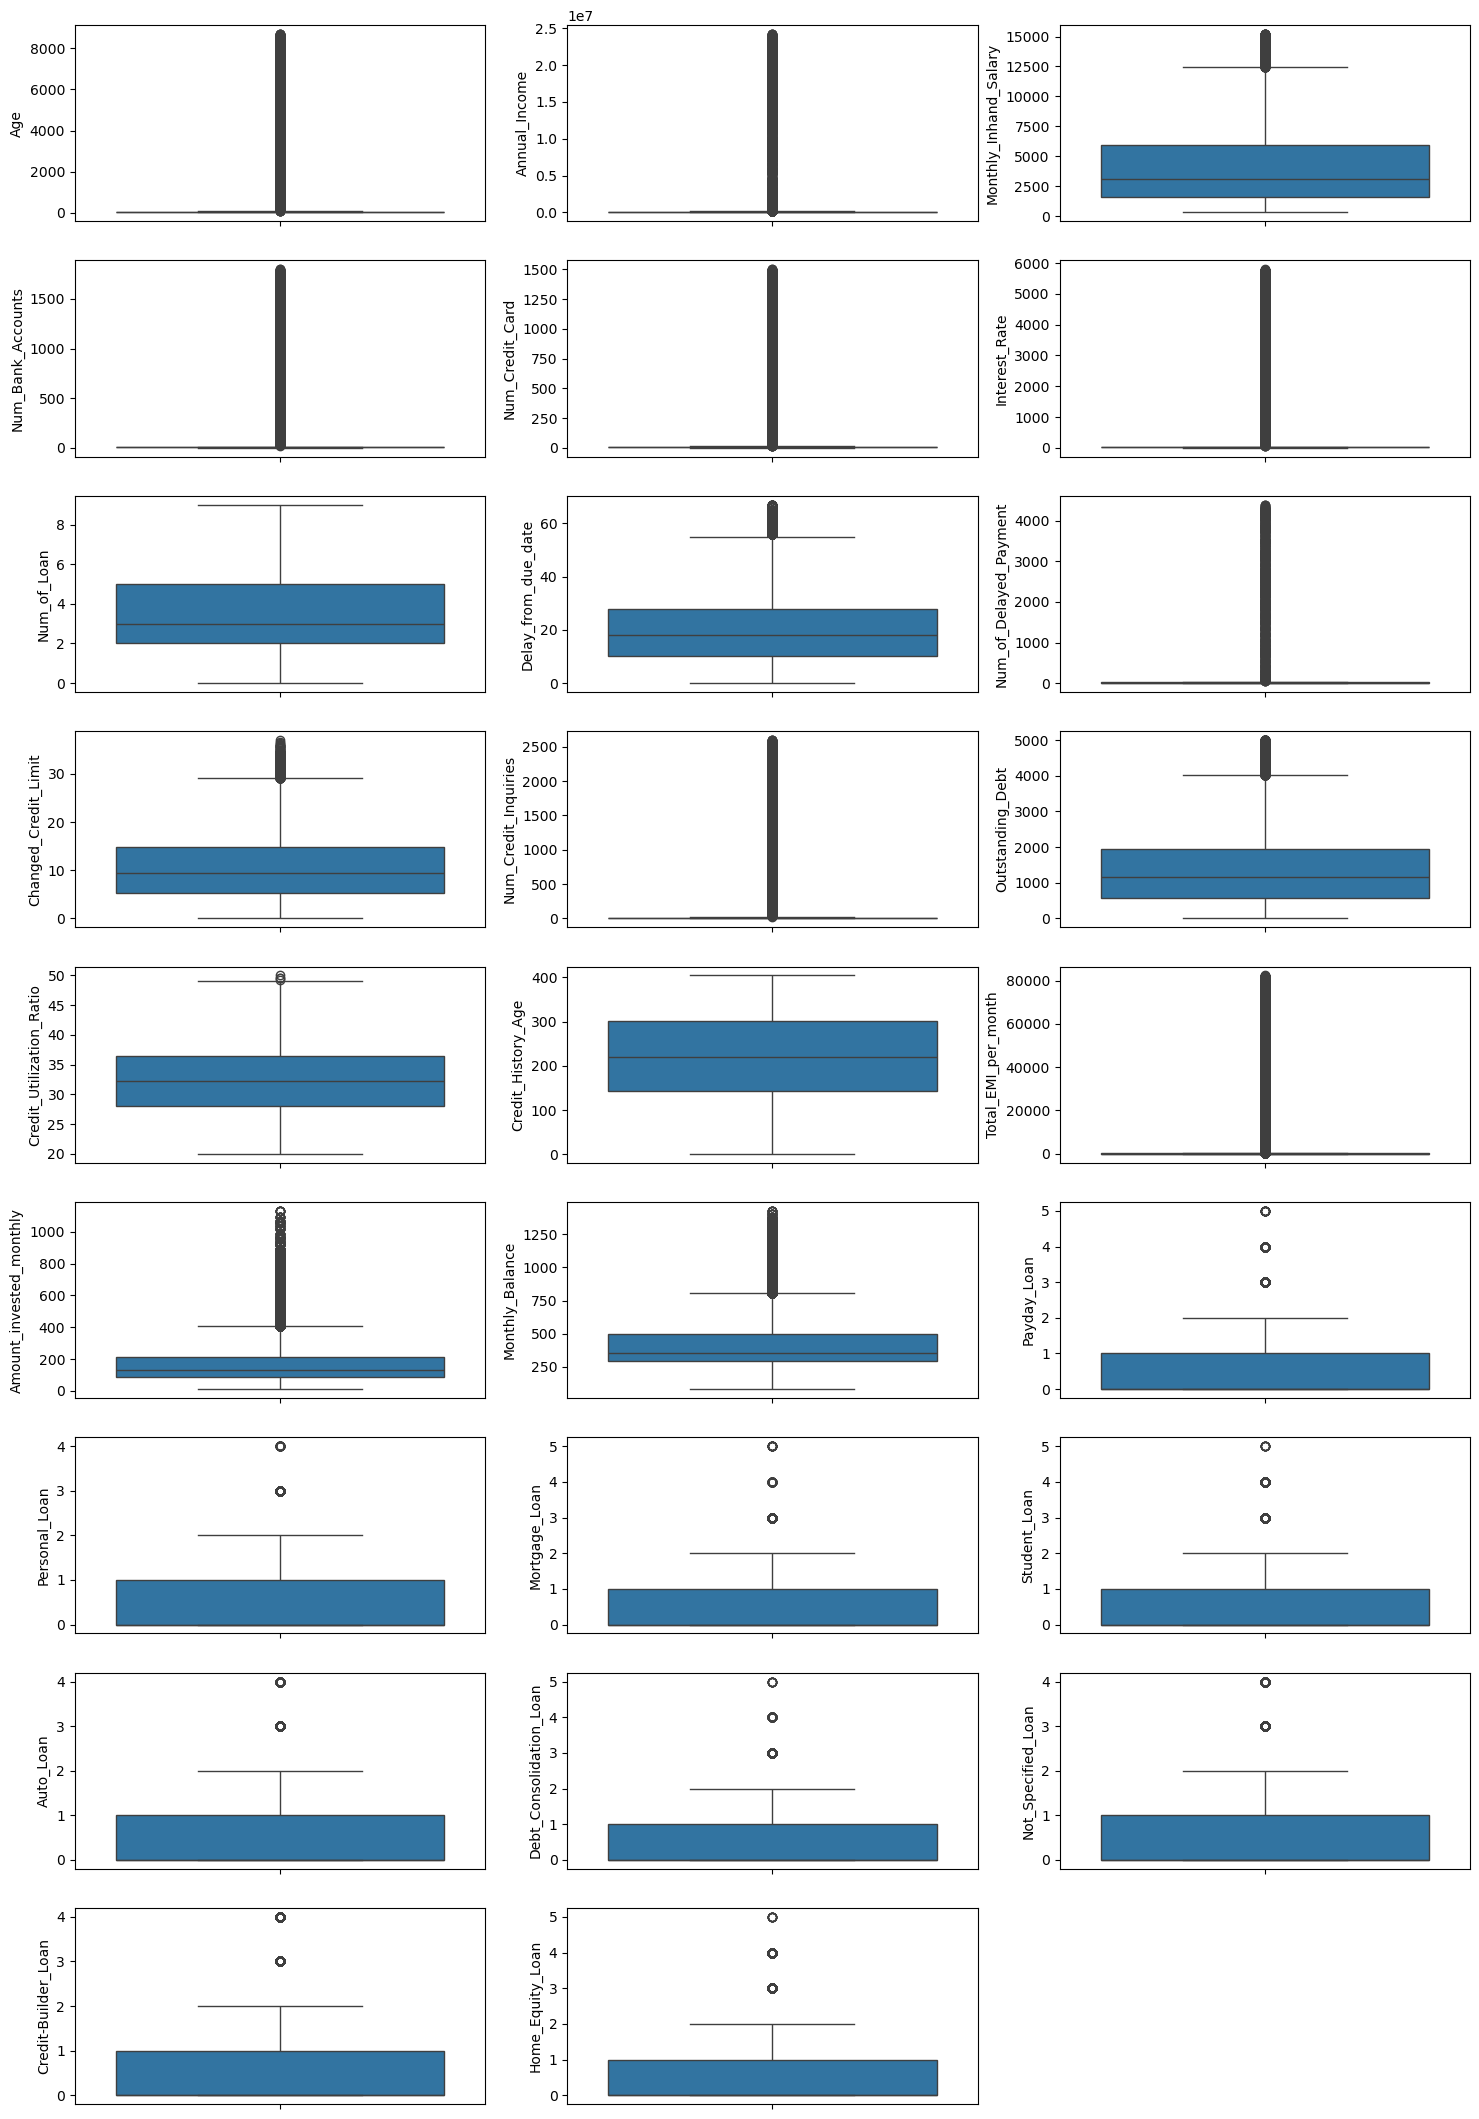

In [72]:
fig, axs = plt.subplots(nrows=9, ncols=3, figsize=(18, 27))

for idx, col in enumerate(num_cols_df7):
    i, j = divmod(idx, 3)
    sns.boxplot(data=df7, y=col, ax=axs[i, j])

axs.flatten()[-1].set_axis_off()

In [73]:
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

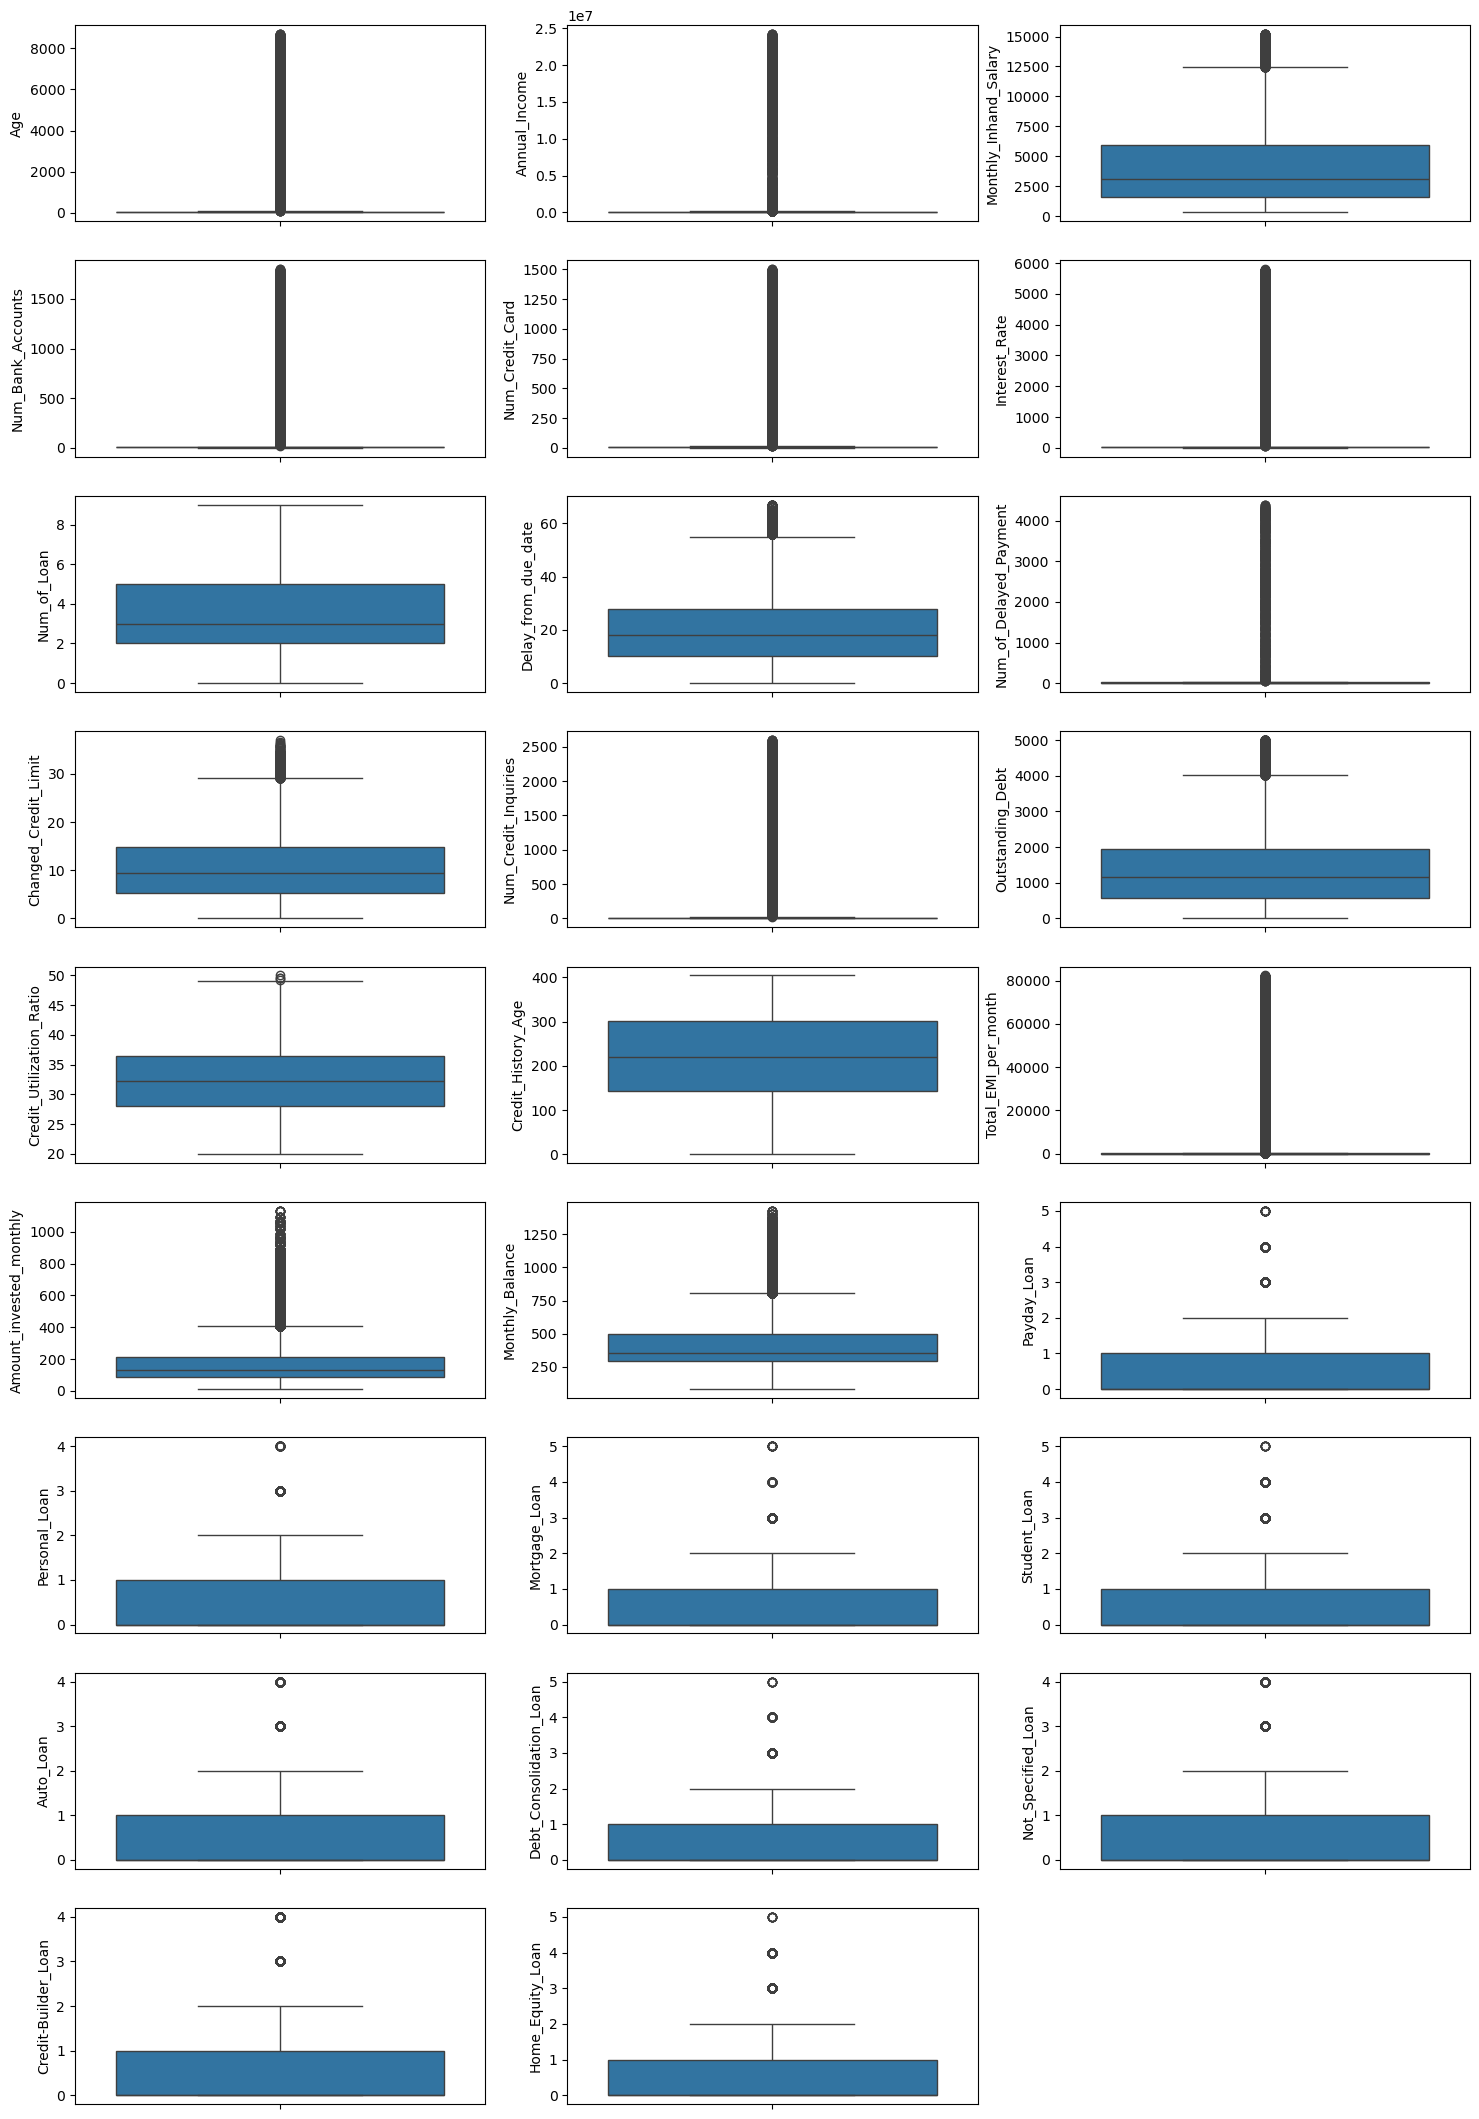

In [74]:
fig, axs = plt.subplots(nrows=9, ncols=3, figsize=(18, 27))

for idx, col in enumerate(num_cols_df7):
    i, j = divmod(idx, 3)
    sns.boxplot(data=df7, y=col, ax=axs[i, j])

axs.flatten()[-1].set_axis_off()

In [75]:
def get_outlier_boundry(s:pd.Series, iqr_multiply_by:int=1.5):
    q1, q3 = np.nanquantile(s, [.25, .75])
    iqr = q3 - q1

    cut_off = iqr * iqr_multiply_by
    lower_bound, upper_bound = q1-cut_off, q3+cut_off

    return lower_bound, upper_bound

In [76]:
def has_outliers(s:pd.Series, iqr_multiply_by:int=1.5):
    lower_bound, upper_bound = get_outlier_boundry(s, iqr_multiply_by=iqr_multiply_by)
    return s[(s<lower_bound) | (s> upper_bound)].any()

In [77]:
def get_cols_with_outliers(df:pd.DataFrame, cols:list):
    cols_with_outliers = []
    for col in cols:
        if has_outliers(df[col], 1.75):
            cols_with_outliers.append(col)
    return cols_with_outliers

In [78]:
numeric_cols_df7 = df7.select_dtypes(include=np.number).columns.to_list()

In [79]:
cols_with_outliers = get_cols_with_outliers(df7, numeric_cols_df7)

In [80]:
cols_with_outliers

['Age',
 'Annual_Income',
 'Monthly_Inhand_Salary',
 'Num_Bank_Accounts',
 'Num_Credit_Card',
 'Interest_Rate',
 'Delay_from_due_date',
 'Num_of_Delayed_Payment',
 'Changed_Credit_Limit',
 'Num_Credit_Inquiries',
 'Outstanding_Debt',
 'Total_EMI_per_month',
 'Amount_invested_monthly',
 'Monthly_Balance',
 'Payday_Loan',
 'Personal_Loan',
 'Mortgage_Loan',
 'Student_Loan',
 'Auto_Loan',
 'Debt_Consolidation_Loan',
 'Not_Specified_Loan',
 'Credit-Builder_Loan',
 'Home_Equity_Loan']

In [81]:
list(
    set(numeric_cols_df7) - set(cols_with_outliers)
)

['Credit_Utilization_Ratio', 'Num_of_Loan', 'Credit_History_Age']

In [82]:
cols_with_outliers_to_check = ['Age', 'Annual_Income', 'Num_Bank_Accounts', 'Num_Credit_Card', 
                               'Interest_Rate', 'Num_of_Delayed_Payment', 'Num_Credit_Inquiries',
                               'Total_EMI_per_month', 'Amount_invested_monthly']

In [83]:
def generate_anomalies_report(df:pd.DataFrame, cols:list, verbose=False):
    parameters_list = []
    for col in cols:
        series = df[col]
        lower_bound, upper_bound = get_outlier_boundry(series)
        if verbose:
            parameters_list.append( [lower_bound, series.min(), 
                                     series.max(), upper_bound, 
                                     series.median(), series.mean(), series.mode().iat[0]] )
        else:
            parameters_list.append( [lower_bound, series.min(), 
                                     series.max(), upper_bound] )
    df = (
        pd.DataFrame(parameters_list, index=cols)
        .rename(columns={0:"Outlier_Lower_Bound", 
                         1:"Min",
                         2:"Max",
                         3:"Outlier_Upper_Bound"})
        )

    if verbose:
        df = (
            pd.DataFrame(parameters_list, index=cols)
            .rename(columns={0:"Outlier_Lower_Bound", 
                             1:"Min",
                             2:"Max",
                             3:"Outlier_Upper_Bound",
                             4: "Mean",
                             5: "Median",
                             6: "Mode"})
            )
        
    return df

In [84]:
with pd.option_context( 'display.float_format', '{:.3f}'.format ):
    display(
        generate_anomalies_report(df7, cols_with_outliers_to_check, verbose=True)
    )

,Outlier_Lower_Bound,Min,Max,Outlier_Upper_Bound,Mean,Median,Mode
Age,-0.500,14.000,8698.000,67.500,34.000,119.510,38.000
Annual_Income,-60542.630,7005.930,24198062.000,152791.050,37578.610,176415.701,9141.630
Num_Bank_Accounts,-3.000,0.000,1798.000,13.000,6.000,17.092,6.000
Num_Credit_Card,-0.500,0.000,1499.000,11.500,5.000,22.474,5.000
Interest_Rate,-10.000,1.000,5797.000,38.000,13.000,72.466,8.000
Num_of_Delayed_Payment,-4.500,0.000,4397.000,31.500,14.000,29.709,19.000
Num_Credit_Inquiries,-6.000,0.000,2597.000,18.000,6.000,27.321,4.000
Total_EMI_per_month,-166.070,0.000,82331.000,357.601,69.249,1403.118,0.000
Amount_invested_monthly,-103.483,10.659,1132.670,405.641,132.912,171.245,10.659


In [85]:
def get_all_outliers_indices(df:pd.DataFrame, cols:list):
    outliers_indices = []
    for col in cols:
        series = df[col]
        lower_bound, upper_bound = get_outlier_boundry(series)
        series_outliers_indices = series[(series<lower_bound) | (series>upper_bound)].index.to_list()
        outliers_indices.extend(series_outliers_indices)
    return list( set(outliers_indices) )

In [86]:
outliers_indices = get_all_outliers_indices(df7, cols_with_outliers_to_check)

In [87]:
len(outliers_indices)

21969

In [88]:
df_outliers_subset = df7.loc[outliers_indices, :]

In [89]:
outliers_credit_scores = df_outliers_subset.Credit_Score.value_counts().reindex(['Poor', 'Standard', 'Good'])
outliers_credit_scores

Credit_Score
Poor         5443
Standard    11396
Good         5130
Name: count, dtype: int64

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.bar(outliers_credit_scores.index, outliers_credit_scores.values)

ax.set_title("Outliers' Credit Score Distribution")

ax.spines[['top', 'right']].set_visible(False)

In [ ]:
def get_df_all_customers_with_outliers(df:pd.DataFrame, col):
    series = df[col]
    lower_bound, upper_bound = get_outlier_boundry(series, iqr_multiply_by=1.75)
    series_outliers_indices = series[(series<lower_bound) | (series>upper_bound)].index.to_list()
    customer_ids = df[(series<lower_bound) | (series>upper_bound)].Customer_ID.unique()
    return df[df.Customer_ID.isin(customer_ids)]

In [ ]:
for col in cols_with_outliers_to_check:
    df_otlrs = get_df_all_customers_with_outliers(df7, col)
    display(display_group_counts_per_customer_id(df_otlrs, col))

In [ ]:
cols_groupby_transform_by_mode = ['Age', 'Annual_Income', 'Num_Bank_Accounts', 'Num_Credit_Card', 
                                  'Interest_Rate', 'Total_EMI_per_month', 'Amount_invested_monthly',
                                  'Monthly_Inhand_Salary', 'Name', 'SSN', 'Type_of_Loan',
                                  'Credit_Mix', 'Payment_of_Min_Amount', 'Type_of_Loan']

cols_convert_outliers_nan = ['Num_of_Delayed_Payment', 'Num_Credit_Inquiries']

cols_fillna_by_mode_per_customer = ['Num_of_Delayed_Payment', 'Changed_Credit_Limit', 
                                    'Num_Credit_Inquiries', 'Payment_Behaviour']

cols_fillna_by_mode_per_customer += cols_convert_outliers_nan

cols_fillna_by_median_per_customer = ['Amount_invested_monthly', 'Monthly_Balance']

In [ ]:
def convert_outliers_nan(df:pd.DataFrame, col):
    series = df[col]
    lower_bound, upper_bound = get_outlier_boundry(series)

    return np.where(
        series > upper_bound, pd.NA,
        np.where(series < lower_bound, pd.NA, series)
            )

In [ ]:
df8 = (
    df.Credit_History_Age.str.extract(r'(\d+) Years and (\d+) Months')
    .rename(columns={0:'Credit_History_Years', 1:'Credit_History_Months'})
    .pipe(lambda df_: pd.concat([df, df_], axis=1))
    .assign(**{c: lambda df_, c=c: pd.to_numeric(df_[c]) for c in ['Credit_History_Years', 'Credit_History_Months']})
    .assign( Credit_History_Age = lambda df_: df_.Credit_History_Years*12 + df_.Credit_History_Months)
    .pipe(lambda df_: df_.drop(['Credit_History_Years', 'Credit_History_Months'], axis=1))
    .assign(**{c: lambda df_, c=c: df_[c].replace(strange_vals_mapping) for c in cols_to_num})
    .assign(**{c: lambda df_, c=c: sanitize_numeric_series_enhanced(df_[c]) for c in numeric_cols})
    .assign(**{c: lambda df_, c=c: df_[c].replace('', pd.NA) for c in cols_to_num})
    .assign(**{c: lambda df_, c=c: pd.to_numeric(df_[c]) for c in numeric_cols})
    .assign(
        SSN = lambda df_: df_.SSN.replace('#F%$D@*&8', pd.NA),
        Credit_Mix = lambda df_: df_.Credit_Mix.replace('_', pd.NA),
        Payment_of_Min_Amount = lambda df_: df_.Payment_of_Min_Amount.replace('NM', pd.NA),
        Payment_Behaviour = lambda df_: df_.Payment_Behaviour.replace('!@9#%8', pd.NA),
    )
    .assign(
        **{c: lambda df_, c=c: ( df_.groupby(['Customer_ID'])[c]
                                .transform( lambda x: get_mode(x) )
                               ) for c in cols_groupby_transform_by_mode}
    )
    .assign(
        **{c: lambda df_, c=c: ( convert_outliers_nan(df_, c)
                               ) for c in cols_convert_outliers_nan}
    )
    .assign(
        **{c: lambda df_, c=c: ( df_.groupby(['Customer_ID'])[c]
                                .transform( lambda x: x.fillna(x.mode().iat[0]) )
                               ) for c in cols_fillna_by_mode_per_customer}
    )
    .assign(
        **{c: lambda df_, c=c: ( df_.groupby(['Customer_ID'])[c]
                                .transform( lambda x: x.median() )
                               ) for c in cols_fillna_by_median_per_customer}
    )
    .assign(
        Credit_History_Age = lambda _df: _df.groupby(['Customer_ID'])['Credit_History_Age'].transform(
            lambda x: x.fillna(x.ffill()+1) )
    )
    .assign(
        Credit_History_Age = lambda _df: _df.groupby(['Customer_ID'])['Credit_History_Age'].transform(
            lambda x: x.fillna(x.bfill()-1) )
    )
    .pipe( lambda df_: pd.concat([df_, generate_loans_types_serieses(df_.Type_of_Loan)], axis=1) )
    .pipe( lambda df_: df_.drop(['Type_of_Loan'], axis=1) )
    .assign( Num_of_Loan = lambda df_: df_.loc[:, loans_cols].sum(axis=1) )
)


In [ ]:
df8.info()

In [ ]:
display_df_desc(df8)

In [ ]:
fig, axs = plt.subplots(nrows=9, ncols=3, figsize=(18, 27))

for idx, col in enumerate(num_cols_df7):
    i, j = divmod(idx, 3)
    sns.boxplot(data=df8, y=col, ax=axs[i, j])

axs.flatten()[-1].set_axis_off()

In [ ]:
with pd.option_context( 'display.float_format', '{:.3f}'.format ):
    display(
        generate_anomalies_report(df8, cols_with_outliers_to_check)
    )

In [ ]:
# class Preprocessor:

#     cols_to_num = ('Age', 'Annual_Income', 'Num_of_Loan', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
#                    'Outstanding_Debt', 'Amount_invested_monthly', 'Monthly_Balance')
    
#     int_cols = ('Age', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Num_of_Loan', 'Delay_from_due_date', 
#                 'Num_of_Delayed_Payment', 'Num_Credit_Inquiries', 'Credit_History_Age')

#     float_cols = ('Annual_Income', 'Changed_Credit_Limit', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 
#                   'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance')

#     cols_groupby_transform_by_mode = ['Monthly_Inhand_Salary', 'Name', 'SSN', 'Type_of_Loan',
#                               'Credit_Mix', 'Payment_of_Min_Amount', 'Type_of_Loan']

#     cols_fillna_by_mode_per_customer = ['Num_of_Delayed_Payment', 'Changed_Credit_Limit', 
#                                         'Num_Credit_Inquiries', 'Payment_Behaviour']
    
#     cols_fillna_by_median_per_customer = ['Amount_invested_monthly', 'Monthly_Balance']

#     df = None
    
    
#     def fit(self, dataframe:pd.DataFrame):
#         self.df = dataframe


#     def reload_with_updated_df(self):
#         new_processor = Preprocessor()
#         new_processor.fit(self.df)
#         return new_processor

    
#     def transform(self):
#         return (
#             self.transform_credit_history_age()
#             .sanitize_numerical_columns()
#             .sanitize_categorical_columns()
#             .transform_by_mode_per_customer()
#             .fillna_by_mode_per_customer()
#             .fill_credit_history_age()
#         ).df


#     def transform_credit_history_age(self):
#         self.df = (
#             self.df.Credit_History_Age.str.extract(r'(\d+) Years and (\d+) Months')
#             .rename(columns={0:'Credit_History_Years', 1:'Credit_History_Months'})
#             .pipe(lambda df_: pd.concat([self.df, df_], axis=1))
#             .assign(**{c: lambda df_, c=c: pd.to_numeric(df_[c]) for c in ['Credit_History_Years', 'Credit_History_Months']})
#             .assign( Credit_History_Age = lambda df_: df_.Credit_History_Years*12 + df_.Credit_History_Months)
#             .pipe(lambda df_: df_.drop(['Credit_History_Years', 'Credit_History_Months'], axis=1))
#         )
              
#         # return self
#         return self.reload_with_updated_df()

    
#     def sanitize_numerical_columns(self):

#         numeric_cols = self.int_cols + self.float_cols

#         strange_vals_mapping = {'__-333333333333333333333333333__': pd.NA, 
#                                 '__10000__': pd.NA}

#         self.df = (
#                     self.df.assign(**{c: lambda df_, c=c: df_[c].replace(strange_vals_mapping) for c in cols_to_num})
#                     .assign(**{c: lambda df_, c=c: self._sanitize_numeric_series_enhanced(df_[c]) for c in numeric_cols})
#                     .assign(**{c: lambda df_, c=c: df_[c].replace('', pd.NA) for c in cols_to_num})
#                     .assign(**{c: lambda df_, c=c: pd.to_numeric(df_[c]) for c in numeric_cols})
#                 )

#         # return self
#         return self.reload_with_updated_df()


#     def sanitize_categorical_columns(self):

#         self.df = self.df.assign(
#                         SSN = lambda df_: df_.SSN.replace('#F%$D@*&8', pd.NA),
#                         Credit_Mix = lambda df_: df_.Credit_Mix.replace('_', pd.NA),
#                         Payment_of_Min_Amount = lambda df_: df_.Payment_of_Min_Amount.replace('NM', pd.NA),
#                         Payment_Behaviour = lambda df_: df_.Payment_Behaviour.replace('!@9#%8', pd.NA)
#                     )

#         # return self
#         return self.reload_with_updated_df()


#     def transform_by_mode_per_customer(self):
#         self.df = self.df.assign( **{c: lambda df_, c=c: ( df_.groupby(['Customer_ID'])[c]
#                                       .transform( lambda x: self._get_mode(x) )
#                                     ) for c in cols_groupby_transform_by_mode})

#         # return self
#         return self.reload_with_updated_df()

        
#     def fillna_by_mode_per_customer(self):
#         self.df = self.df.assign(
#             **{c: lambda _df, c=c: ( _df.groupby(['Customer_ID'])[f'{c}']
#                                     .transform( lambda x: x.fillna(x.mode().iat[0]) )
#                                    ) for c in cols_fillna_by_mode_per_customer})

#         # return self
#         return self.reload_with_updated_df()

    
#     def transform_type_of_loans(self):
#         self.df = self.df.pipe( 
#             lambda df_: pd.concat([df_, generate_loans_types_serieses(df_.Type_of_Loan)], axis=1) 
#         ).drop(['Type_of_Loan'], axis=1)

#         # return self
#         return self.reload_with_updated_df()

    
#     def fill_credit_history_age(self):
#         self.df = self.df.assign(
#             Credit_History_Age = ( lambda _df: _df.groupby(['Customer_ID'])['Credit_History_Age']
#                                   .transform( lambda x: x.fillna(x.ffill()+1) )
#                                  ) ).assign(
#             Credit_History_Age = ( lambda _df: _df.groupby(['Customer_ID'])['Credit_History_Age']
#                                   .transform( lambda x: x.fillna(x.bfill()-1) ) )
#         )
#         # return self
#         return self.reload_with_updated_df()


#     def _sanitize_numeric_series_enhanced(self, s:pd.Series):
#         return s.astype(str).str.replace(r'[^0-9.]', '', regex=True)

    
#     def _get_loan_types_plus_counters(self, loans_series:pd.Series):
#         # loans_lists_list = loans_series.str.split(r', and |, | and |,').dropna()
#         loans_lists_list = loans_series.str.split(r', and |, | and |,')
    
#         loans_types = set()
#         loans_counters_list = []
    
#         for _, loans_list in loans_lists_list.items():
#             if isinstance(loans_list, list):
#                 loans_types.update(loans_list)
#                 loans_counter = Counter(loans_list)
#                 loans_counters_list.append(loans_counter)
#             else:
#                 loans_counter = Counter()
#                 loans_counters_list.append(loans_counter)
    
#         return list(loans_types), loans_counters_list

    
#     def _generate_loans_types_serieses(self, loans_series:pd.Series):
        
#         loans_types, loans_counters_list = self._get_loan_types_plus_counters(loans_series)
#         loan_types_serieses = defaultdict(list)
    
#         for loan_type in loans_types:
#             for loans_counter in loans_counters_list:
#                 loan_types_serieses[loan_type].append( loans_counter.get(loan_type, 0) )
    
#         df = pd.DataFrame(loan_types_serieses)
#         df.rename(columns={'Not Specified': 'Not Specified Loan'}, inplace=True)
#         df.rename(columns=lambda col: col.replace(' ', '_'), inplace=True)
        
#         return df

    
#     def _get_mode(self, s:pd.Series):
#         if s.isnull().all():
#             return pd.NA
#         else:
#             return s.mode().iat[0]

In [ ]:
# class Preprocessor:

#     cols_to_num = ('Age', 'Annual_Income', 'Num_of_Loan', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
#                    'Outstanding_Debt', 'Amount_invested_monthly', 'Monthly_Balance')
    
#     int_cols = ('Age', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Num_of_Loan', 'Delay_from_due_date', 
#                 'Num_of_Delayed_Payment', 'Num_Credit_Inquiries', 'Credit_History_Age')

#     float_cols = ('Annual_Income', 'Changed_Credit_Limit', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 
#                   'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance')

#     cols_groupby_transform_by_mode = ['Monthly_Inhand_Salary', 'Name', 'SSN', 'Occupation', 'Type_of_Loan',
#                               'Credit_Mix', 'Payment_of_Min_Amount', 'Type_of_Loan']

#     cols_fillna_by_mode_per_customer = ['Num_of_Delayed_Payment', 'Changed_Credit_Limit', 
#                                         'Num_Credit_Inquiries', 'Payment_Behaviour']
    
#     cols_fillna_by_median_per_customer = ['Amount_invested_monthly', 'Monthly_Balance']

#     df = None
    
    
#     def fit(self, dataframe:pd.DataFrame):
#         self.df = dataframe.copy()


#     def reload_with_updated_df(self, transformed_df: pd.DataFrame):
#         new_processor = Preprocessor()
#         new_processor.fit(transformed_df)
#         return new_processor

    
#     def transform(self):
#         return (
#             self.transform_credit_history_age()
#             .sanitize_numerical_columns()
#             .sanitize_categorical_columns()
#             .transform_by_mode_per_customer()
#             .fillna_by_mode_per_customer()
#             .fillna_by_median_per_customer()
#             .fill_credit_history_age()
#             .transform_type_of_loans()
#             .transform_num_of_loans()
#             .render_output_df()
#         ).df


#     def transform_credit_history_age(self):
#         transformed_df = (
#             self.df.Credit_History_Age.str.extract(r'(\d+) Years and (\d+) Months')
#             .rename(columns={0:'Credit_History_Years', 1:'Credit_History_Months'})
#             .pipe(lambda df_: pd.concat([self.df, df_], axis=1))
#             .assign(**{c: lambda df_, c=c: pd.to_numeric(df_[c]) for c in ['Credit_History_Years', 'Credit_History_Months']})
#             .assign( Credit_History_Age = lambda df_: df_.Credit_History_Years*12 + df_.Credit_History_Months)
#             .pipe(lambda df_: df_.drop(['Credit_History_Years', 'Credit_History_Months'], axis=1))
#         )
              
#         return self.reload_with_updated_df(transformed_df)

    
#     def sanitize_numerical_columns(self):

#         numeric_cols = self.int_cols + self.float_cols

#         strange_vals_mapping = {'__-333333333333333333333333333__': pd.NA, 
#                                 '__10000__': pd.NA}

#         transformed_df = (
#                     self.df.assign(**{c: lambda df_, c=c: df_[c].replace(strange_vals_mapping) for c in cols_to_num})
#                     .assign(**{c: lambda df_, c=c: self._sanitize_numeric_serieses(df_[c]) for c in numeric_cols})
#                     .assign(**{c: lambda df_, c=c: df_[c].replace('', pd.NA) for c in cols_to_num})
#                     .assign(**{c: lambda df_, c=c: pd.to_numeric(df_[c]) for c in numeric_cols})
#                 )

#         return self.reload_with_updated_df(transformed_df)


#     def sanitize_categorical_columns(self):

#         transformed_df = self.df.assign(
#                         SSN = lambda df_: df_.SSN.replace('#F%$D@*&8', pd.NA),
#                         Credit_Mix = lambda df_: df_.Credit_Mix.replace('_', pd.NA),
#                         Payment_of_Min_Amount = lambda df_: df_.Payment_of_Min_Amount.replace('NM', pd.NA),
#                         Payment_Behaviour = lambda df_: df_.Payment_Behaviour.replace('!@9#%8', pd.NA),
#                         Occupation = lambda df_: df_.Occupation.replace('_______', pd.NA)
#                     )

#         return self.reload_with_updated_df(transformed_df)


#     def transform_by_mode_per_customer(self):
#         transformed_df = self.df.assign( **{c: lambda df_, c=c: ( df_.groupby(['Customer_ID'])[c]
#                                       .transform( lambda x: self._get_mode(x) )
#                                     ) for c in self.cols_groupby_transform_by_mode})

#         return self.reload_with_updated_df(transformed_df)

        
#     def fillna_by_mode_per_customer(self):
#         transformed_df = self.df.assign(
#             **{c: lambda _df, c=c: ( _df.groupby(['Customer_ID'])[f'{c}']
#                                     .transform( lambda x: x.fillna(x.mode().iat[0]) )
#                                    ) for c in self.cols_fillna_by_mode_per_customer})

#         return self.reload_with_updated_df(transformed_df)

    
#     def fillna_by_median_per_customer(self):
#         transformed_df = self.df.assign(
#             **{c: lambda _df, c=c: ( _df.groupby(['Customer_ID'])[f'{c}']
#                                     .transform( lambda x: x.median() )
#                                    ) for c in self.cols_fillna_by_median_per_customer})

#         return self.reload_with_updated_df(transformed_df)

    
#     def transform_type_of_loans(self):
#         transformed_df = self.df.pipe( 
#             lambda df_: pd.concat([df_, self._generate_loans_types_serieses(df_.Type_of_Loan)], axis=1) 
#         ).drop(['Type_of_Loan'], axis=1)

#         return self.reload_with_updated_df(transformed_df)


#     def transform_num_of_loans(self):
#         loans_cols = ['Credit-Builder_Loan', 'Mortgage_Loan', 'Student_Loan', 'Auto_Loan', 
#                       'Payday_Loan', 'Personal_Loan', 'Not_Specified_Loan', 'Debt_Consolidation_Loan', 'Home_Equity_Loan']
        
#         transformed_df = self.df.assign( Num_of_Loan = lambda df_: df_.loc[:, loans_cols].sum(axis=1) )
#         return self.reload_with_updated_df(transformed_df)

    
#     def fill_credit_history_age(self):
#         transformed_df = self.df.assign(
#             Credit_History_Age = ( lambda _df: _df.groupby(['Customer_ID'])['Credit_History_Age']
#                                   .transform( lambda x: x.fillna(x.ffill()+1) )
#                                  ) ).assign(
#             Credit_History_Age = ( lambda _df: _df.groupby(['Customer_ID'])['Credit_History_Age']
#                                   .transform( lambda x: x.fillna(x.bfill()-1) ) )
#         )
#         return self.reload_with_updated_df(transformed_df)


#     def render_output_df(self):
#         cols = self.df.columns.to_list()
#         cols.remove('Credit_Score')
#         cols += ['Credit_Score']

#         return self.reload_with_updated_df( self.df.reindex(columns=cols) )


#     def _sanitize_numeric_serieses(self, s:pd.Series):
#         return s.astype(str).str.replace(r'[^0-9.]', '', regex=True)

    
#     def _get_loan_types_plus_counters(self, loans_series:pd.Series):
#         loans_lists_list = loans_series.str.split(r', and |, | and |,')
    
#         loans_types = set()
#         loans_counters_list = []
    
#         for _, loans_list in loans_lists_list.items():
#             if isinstance(loans_list, list):
#                 loans_types.update(loans_list)
#                 loans_counter = Counter(loans_list)
#                 loans_counters_list.append(loans_counter)
#             else:
#                 loans_counter = Counter()
#                 loans_counters_list.append(loans_counter)
    
#         return list(loans_types), loans_counters_list

    
#     def _generate_loans_types_serieses(self, loans_series:pd.Series):
        
#         loans_types, loans_counters_list = self._get_loan_types_plus_counters(loans_series)
#         loan_types_serieses = defaultdict(list)
    
#         for loan_type in loans_types:
#             for loans_counter in loans_counters_list:
#                 loan_types_serieses[loan_type].append( loans_counter.get(loan_type, 0) )
    
#         df = pd.DataFrame(loan_types_serieses)
#         df.rename(columns={'Not Specified': 'Not Specified Loan'}, inplace=True)
#         df.rename(columns=lambda col: col.replace(' ', '_'), inplace=True)
        
#         return df

    
#     def _get_mode(self, s:pd.Series):
#         if s.isnull().all():
#             return pd.NA
#         else:
#             return s.mode().iat[0]

In [ ]:
class Preprocessor:

    cols_to_num = ('Age', 'Annual_Income', 'Num_of_Loan', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
                   'Outstanding_Debt', 'Amount_invested_monthly', 'Monthly_Balance')
    
    int_cols = ('Age', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Num_of_Loan', 'Delay_from_due_date', 
                'Num_of_Delayed_Payment', 'Num_Credit_Inquiries', 'Credit_History_Age')

    float_cols = ('Annual_Income', 'Changed_Credit_Limit', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 
                  'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance')

    numeric_cols = int_cols + float_cols
    
    cols_groupby_transform_by_mode = ['Age', 'Annual_Income', 'Num_Bank_Accounts', 'Num_Credit_Card', 
                                      'Interest_Rate', 'Total_EMI_per_month', 'Amount_invested_monthly',
                                      'Monthly_Inhand_Salary', 'Name', 'SSN', 'Occupation', 'Type_of_Loan',
                                      'Credit_Mix', 'Payment_of_Min_Amount', 'Type_of_Loan']

    cols_fillna_by_mode_per_customer = ['Num_of_Delayed_Payment', 'Changed_Credit_Limit', 
                                        'Num_Credit_Inquiries', 'Payment_Behaviour']
    
    cols_fillna_by_median_per_customer = ['Amount_invested_monthly', 'Monthly_Balance']
    
    cols_convert_outliers_nan = ['Num_of_Delayed_Payment', 'Num_Credit_Inquiries']
    
    cols_fillna_by_mode_per_customer += cols_convert_outliers_nan
    

    df = None

    def __init__(self, iqr_multiply_by:float=1.5):
        self.iqr_multiply_by = iqr_multiply_by
    
    
    def fit(self, dataframe:pd.DataFrame):
        self.df = dataframe


    def reload_with_updated_df(self, transformed_df: pd.DataFrame):
        new_processor = Preprocessor()
        new_processor.fit(transformed_df)
        return new_processor

    
    def transform(self):
        return (
            self.transform_credit_history_age()
            .sanitize_numerical_columns()
            .sanitize_categorical_columns()
            .transform_by_mode_per_customer()
            .nullify_outliers()
            .fillna_by_mode_per_customer()
            .fillna_by_median_per_customer()
            .fill_credit_history_age()
            .transform_type_of_loans()
            .transform_num_of_loans()
            .render_output_df()
        ).df


    def transform_credit_history_age(self):
        transformed_df = (
            self.df.Credit_History_Age.str.extract(r'(\d+) Years and (\d+) Months')
            .rename(columns={0:'Credit_History_Years', 1:'Credit_History_Months'})
            .pipe(lambda df_: pd.concat([self.df, df_], axis=1))
            .assign(**{c: lambda df_, c=c: pd.to_numeric(df_[c]) for c in ['Credit_History_Years', 'Credit_History_Months']})
            .assign( Credit_History_Age = lambda df_: df_.Credit_History_Years*12 + df_.Credit_History_Months)
            .pipe(lambda df_: df_.drop(['Credit_History_Years', 'Credit_History_Months'], axis=1))
        )
              
        return self.reload_with_updated_df(transformed_df)

    
    def sanitize_numerical_columns(self):

        numeric_cols = self.int_cols + self.float_cols

        strange_vals_mapping = {'__-333333333333333333333333333__': pd.NA, 
                                '__10000__': pd.NA}

        transformed_df = (
                    self.df.assign(**{c: lambda df_, c=c: df_[c].replace(strange_vals_mapping) for c in self.cols_to_num})
                    .assign(**{c: lambda df_, c=c: self._sanitize_numeric_serieses(df_[c]) for c in self.numeric_cols})
                    .assign(**{c: lambda df_, c=c: df_[c].replace('', pd.NA) for c in self.cols_to_num})
                    .assign(**{c: lambda df_, c=c: pd.to_numeric(df_[c]) for c in self.numeric_cols})
                )

        return self.reload_with_updated_df(transformed_df)


    def sanitize_categorical_columns(self):

        transformed_df = self.df.assign(
                        SSN = lambda df_: df_.SSN.replace('#F%$D@*&8', pd.NA),
                        Credit_Mix = lambda df_: df_.Credit_Mix.replace('_', pd.NA),
                        Payment_of_Min_Amount = lambda df_: df_.Payment_of_Min_Amount.replace('NM', pd.NA),
                        Payment_Behaviour = lambda df_: df_.Payment_Behaviour.replace('!@9#%8', pd.NA),
                        Occupation = lambda df_: df_.Occupation.replace('_______', pd.NA)
                    )

        return self.reload_with_updated_df(transformed_df)


    def transform_by_mode_per_customer(self):
        transformed_df = self.df.assign( **{c: lambda df_, c=c: ( df_.groupby(['Customer_ID'])[c]
                                      .transform( lambda x: self._get_mode(x) )
                                    ) for c in self.cols_groupby_transform_by_mode})

        return self.reload_with_updated_df(transformed_df)


    def nullify_outliers(self):
        transformed_df = self.df.assign(
            **{c: lambda df_, c=c: self._convert_outliers_to_nan(df_, c) for c in self.cols_convert_outliers_nan}
        )

        return self.reload_with_updated_df(transformed_df)

        
    def fillna_by_mode_per_customer(self):
        transformed_df = self.df.assign(
            **{c: lambda _df, c=c: ( _df.groupby(['Customer_ID'])[c]
                                    .transform( lambda x: x.fillna(x.mode().iat[0]) )
                                   ) for c in self.cols_fillna_by_mode_per_customer})

        return self.reload_with_updated_df(transformed_df)

    
    def fillna_by_median_per_customer(self):
        transformed_df = self.df.assign(
            **{c: lambda _df, c=c: ( _df.groupby(['Customer_ID'])[c]
                                    .transform( lambda x: x.median() )
                                   ) for c in self.cols_fillna_by_median_per_customer})

        return self.reload_with_updated_df(transformed_df)

    
    def transform_type_of_loans(self):
        transformed_df = self.df.pipe( 
            lambda df_: pd.concat([df_, self._generate_loans_types_serieses(df_.Type_of_Loan)], axis=1) 
        ).drop(['Type_of_Loan'], axis=1)

        return self.reload_with_updated_df(transformed_df)


    def transform_num_of_loans(self):
        loans_cols = ['Credit-Builder_Loan', 'Mortgage_Loan', 'Student_Loan', 'Auto_Loan', 
                      'Payday_Loan', 'Personal_Loan', 'Not_Specified_Loan', 'Debt_Consolidation_Loan', 'Home_Equity_Loan']
        
        transformed_df = self.df.assign( Num_of_Loan = lambda df_: df_.loc[:, loans_cols].sum(axis=1) )
        return self.reload_with_updated_df(transformed_df)

    
    def fill_credit_history_age(self):
        transformed_df = self.df.assign(
            Credit_History_Age = ( lambda _df: _df.groupby(['Customer_ID'])['Credit_History_Age']
                                  .transform( lambda x: x.fillna(x.ffill()+1) )
                                 ) ).assign(
            Credit_History_Age = ( lambda _df: _df.groupby(['Customer_ID'])['Credit_History_Age']
                                  .transform( lambda x: x.fillna(x.bfill()-1) ) )
        )
        return self.reload_with_updated_df(transformed_df)


    def render_output_df(self):
        cols = self.df.columns.to_list()
        cols.remove('Credit_Score')
        cols += ['Credit_Score']

        return self.reload_with_updated_df( self.df.reindex(columns=cols) )


    def _sanitize_numeric_serieses(self, s:pd.Series):
        return s.astype(str).str.replace(r'[^0-9.]', '', regex=True)

    
    def _get_loan_types_plus_counters(self, loans_series:pd.Series):
        loans_lists_list = loans_series.str.split(r', and |, | and |,')
    
        loans_types = set()
        loans_counters_list = []
    
        for _, loans_list in loans_lists_list.items():
            if isinstance(loans_list, list):
                loans_types.update(loans_list)
                loans_counter = Counter(loans_list)
                loans_counters_list.append(loans_counter)
            else:
                loans_counter = Counter()
                loans_counters_list.append(loans_counter)
    
        return list(loans_types), loans_counters_list

    
    def _generate_loans_types_serieses(self, loans_series:pd.Series):
        
        loans_types, loans_counters_list = self._get_loan_types_plus_counters(loans_series)
        loan_types_serieses = defaultdict(list)
    
        for loan_type in loans_types:
            for loans_counter in loans_counters_list:
                loan_types_serieses[loan_type].append( loans_counter.get(loan_type, 0) )
    
        df = pd.DataFrame(loan_types_serieses)
        df.rename(columns={'Not Specified': 'Not Specified Loan'}, inplace=True)
        df.rename(columns=lambda col: col.replace(' ', '_'), inplace=True)
        
        return df

    
    def _get_mode(self, s:pd.Series):
        if s.isnull().all():
            return pd.NA
        else:
            return s.mode().iat[0]

    
    def _convert_outliers_to_nan(self, df:pd.DataFrame, col):
        series = df[col]
        lower_bound, upper_bound = self._get_outlier_boundry(series)
    
        return np.where(
            series > upper_bound, pd.NA,
            np.where(series < lower_bound, pd.NA, series)
                )

    def _get_outlier_boundry(self, s:pd.Series):
        q1, q3 = np.nanquantile(s, [.25, .75])
        iqr = q3 - q1
    
        cut_off = iqr * self.iqr_multiply_by
        lower_bound, upper_bound = q1-cut_off, q3+cut_off
    
        return lower_bound, upper_bound

In [ ]:
processor = Preprocessor()

In [ ]:
processor.fit(df)

In [ ]:
start = datetime.now()

df_transformed = processor.transform()

total_run_time = (datetime.now() - start).total_seconds()
print(f'{round(total_run_time)} seconds')

In [ ]:
df_transformed.info()

In [ ]:
display_dataframe(df_transformed)

In [ ]:
display_df_desc(df_transformed)

In [ ]:
num_cols_after_transformation = df_transformed.select_dtypes(include=np.number).columns

In [ ]:
num_cols_after_transformation

In [ ]:
fig, axs = plt.subplots(nrows=9, ncols=3, figsize=(18, 27))

for idx, col in enumerate(num_cols_after_transformation):
    i, j = divmod(idx, 3)
    sns.boxplot(data=df_transformed, y=col, ax=axs[i, j])

axs.flatten()[-1].set_axis_off()

In [ ]:
with pd.option_context( 'display.float_format', '{:.3f}'.format ):
    display(
        generate_anomalies_report(df_transformed, num_cols_after_transformation)
    )

In [ ]:
df_transformed.to_csv('credit_classification_data_clean.csv', index=False)